# Аналитика в авиакомпании  
_________________________

В настоящей части проекта проанализируем данные о загруженности принимающих аэропортов в городах России и использовании моделей воздушных судов.

#### Оглавление: 
<a class="anchor" id="step_0"></a>  

* [1. Загрузка файлов с данными и изучение общей информации.](#step_1) 
* [2. Построение графиков](#step_2)
* [2. Выводы](#step_3)

In [1]:
import pandas as pd # Импортируем необходимые библиотеки
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import geocoder
from shapely.geometry import Point
from geopandas import GeoDataFrame
import requests
from yaml import load, FullLoader
import json
import pandas as pd
from tqdm import tqdm

gbs = "\033[1m" # переменная для цвета в коде начало
gbe = "\033[0m"  # переменная для цвета в коде конец

import warnings # отключим предупреждения анаконды
warnings.filterwarnings('ignore')
sns.set() # Стилизуем графики
sns.set_style("white")
# plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(20,6) # Зададим размер графиков по умолчанию
pd.options.display.float_format = '{:.2f}'.format # Зададим удобный формат отображения вещественных чисел

In [2]:
# Функция если понадобится получить имя фрейма или серии. Ну или любого объекта в тетради
def get_name(obj):
    name =[x for x in globals() if globals()[x] is obj][0]
    return name

### 1. Загрузка файлов и изучение общей информации

<a class="anchor" id="step_1"></a>

[В оглавление](#step_0)

In [3]:
# Загрузим датасеты
try:
    models_df = pd.read_csv('/Users/victorchudnovskiy/Documents/raw_csv/query_1.csv')
    cities_df = pd.read_csv('/Users/victorchudnovskiy/Documents/raw_csv/query_3.csv')
except:
    models_df = pd.read_csv('https://code.s3.yandex.net/datasets/query_1.csv')
    cities_df = pd.read_csv('https://code.s3.yandex.net/datasets/query_3.csv')

Выведем первые 5 строк в каждом датафрейме

In [4]:
# Приготовим список для группового вывода содной информации
df_list = [models_df, cities_df]

In [5]:
for df in df_list:
    display(df.head())
    display(df.info())

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


None

,city,average_flights
0,Абакан,3.87
1,Анадырь,1.00
2,Анапа,2.16
3,Архангельск,5.35
4,Астрахань,2.45


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


None

Выведем общую информацию и статистики по двум датафреймам

#### Вывод. 
Полученные датафреймы очень немногочисленны. Данные представлены своими форматами. Пропусков и дубликатов нет

### 2. Построение графиков
<a class="anchor" id="step_2"></a>

[В оглавление](#step_0)

In [6]:
# Извлекаем hex коды цветовой палитры
palette = 'GnBu_d'
pal = sns.color_palette(palette)
pal.as_hex()

['#94d1bf', '#73c0c4', '#53afc9', '#4095b6', '#3c758b', '#37535e']

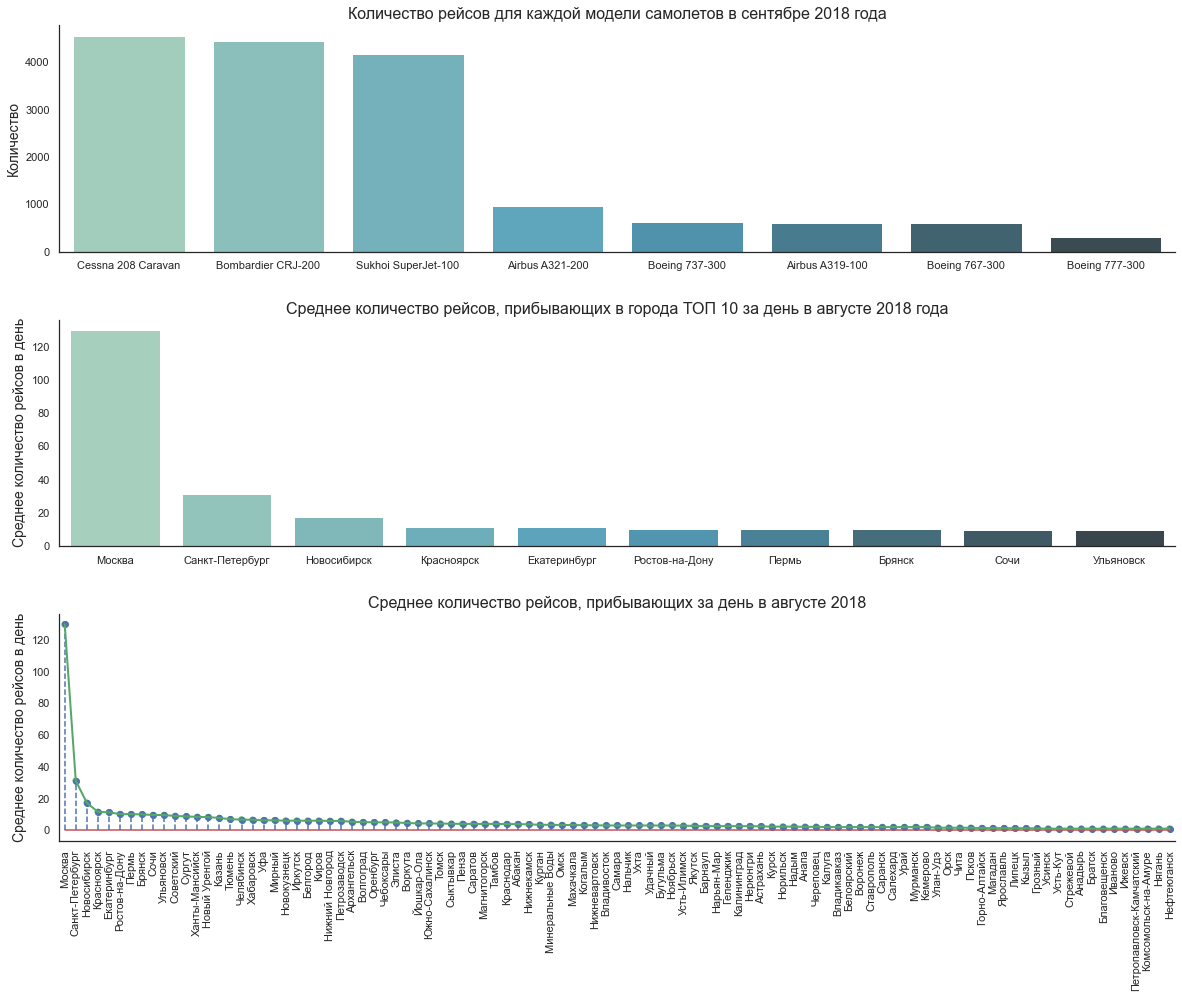

In [7]:
# Выведем на одном холсте два графика
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
sns.barplot(x = 'model', y = 'flights_amount', 
            data = models_df.sort_values(by='flights_amount', ascending=False), 
            estimator = sum, palette=palette,
            ax = axs[0])
axs[0].set_title('Количество рейсов для каждой модели самолетов в сентябре 2018 года', size=16)
axs[0].set_ylabel('Количество', fontsize = 14)
axs[0].set_xlabel('', fontsize = 14)

sns.barplot(x = 'city', y = 'average_flights', 
            data = cities_df.sort_values(by='average_flights', ascending=False).head(10), palette=palette,
            estimator=sum, ax = axs[1])
axs[1].set_title('Среднее количество рейсов, прибывающих в города ТОП 10 за день в августе 2018 года', size=16)
axs[1].set_ylabel('Среднее количество рейсов в день', fontsize = 14)
axs[1].set_xlabel('', fontsize = 14)

ordered_df = cities_df.sort_values(by='average_flights', ascending=False)
my_range=range(len(cities_df.index))

axs[2] = plt.stem(ordered_df['average_flights'], linefmt='--')

sns.pointplot(x=ordered_df['city'], y=ordered_df['average_flights'],
              data=ordered_df, dodge=0.532, join=True, color='g',
              markers="o", scale=0.75, ci=None)

plt.xticks( my_range, ordered_df['city'], rotation = 90)
plt.title('Среднее количество рейсов, прибывающих за день в августе 2018', size=16)
plt.ylabel('Среднее количество рейсов в день', fontsize = 14)
plt.xlabel('', fontsize = 14)

sns.despine()
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.subplots
plt.show()

In [8]:
rus_map = gpd.read_file('/Users/victorchudnovskiy/Documents/raw_csv/geo.json')

In [9]:
def get_geo(address):
    lat = geocoder.osm(address).json['lat']
    lon = geocoder.osm(address).json['lng']
    return lat, lon

In [10]:
cities_df['lat'] = cities_df['city'].apply(lambda x: get_geo(x)[0])
cities_df['lon'] = cities_df['city'].apply(lambda x: get_geo(x)[1])

In [11]:
top_flights = cities_df.sort_values(by='average_flights', ascending=False).head(10).reset_index(drop=True)

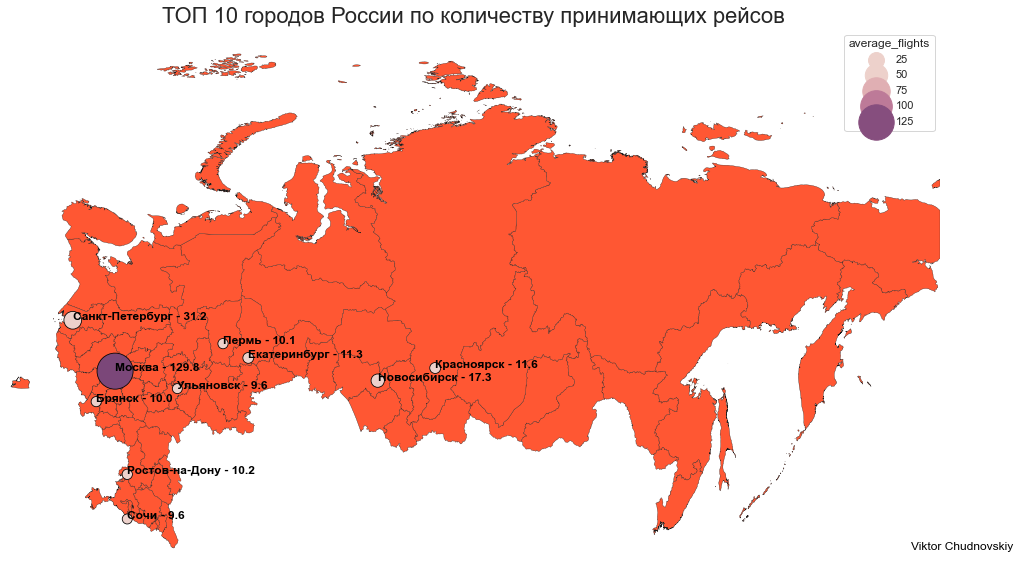

In [13]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(23, 10))
rus_map.plot(color='#FF5733', linewidth=0.3, ax=axs, edgecolor='0.1').set_xlim([19, 180])
sns.despine()


sns.scatterplot(data=top_flights, 
                x="lon", 
                y="lat", 
                hue="average_flights", 
                size="average_flights", 
                sizes=(100, 1300),
                hue_norm=(60, 160),
                color='r',
                edgecolor='0.01',
                ax = axs)
    
for i in range(top_flights.shape[0]):
    city_name = top_flights.loc[i,].to_list()[0]
    lon = top_flights.loc[i,].to_list()[2]
    lat = top_flights.loc[i,].to_list()[3]
    val = top_flights.loc[i,].to_list()[1]
    axs.text(lat, lon, f'{city_name} - {val:.1f}', fontsize=12, weight='bold',  color='black')
    

axs.text(175, 41, 'Viktor Chudnovskiy', fontsize=12,  color='black')
axs.axis('off')
plt.title('ТОП 10 городов России по количеству принимающих рейсов', size=22)
plt.show()

### 3. Выводы
<a class="anchor" id="step_3"></a>

[В оглавление](#step_0)

Согласно первому графику перелеты в России чаще осуществляют малые и среднемагистральные самолеты. Причем чем меньше самолет тем больше перелетов. Это и понятно - малые самолеты не требуют длинных ВПП, экономичны в эксплуатации. Из минусов - мало принимают на борт. От того и летают как челноки.  

Более полезным нам видится график с информацией о топ-10 городов по количеству рейсов. Москва однозначно впереди всея Руси, как-никак 3 международных аэропорта + Жуковский + Быково. Даже Санкт-Петербург со своими Эрмитажами, разводными мостами, романтикой белых ночей и барабулькой принимает лишь четверть московских перелетов. На третьем месте столица Сибири Новосибирск. Там за частую происходят стыковочные перелеты. Остальные города принимают примерно одинаковое количество рейсов. Скорее всего это связано неплотностью сети аэропортов, огромными расстояниями между городами, а особенно за Уралом и как следствие недешевостью авиаперевозок. В итоге чем слетать увидеть Алтай проще оказаться в Австрийских Альпах.